In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyrtools as pt
import plenoptic as po
import scipy.io as sio
import os.path as op
import glob
from tqdm import tqdm
from PIL import Image
directory = '/Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/'
%load_ext autoreload
%autoreload 2
import os
 
def ls(directory):
    return [os.path.join(directory, file) for file in glob.glob(f'{directory}*.jpg')]

torch.__version__
numpy = lambda x: x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
n = 256
im = po.load_images(directory+'10D_2988_2.jpg') # 5DmkII_3874.jpg
m1 = im.mean().detach().numpy()-.05
m2 = im.mean().detach().numpy()+.05
initial_image = np.random.rand(n,n)*(m2-m1) + m1
model = po.simul.Portilla_Simoncelli([n,n],n_scales=4, n_orientations=4, spatial_corr_width=9,use_true_correlations=True)       


In [34]:
met = po.synth.Metamer(im[0,0,:n,:n], model)
# m=met.synthesize(learning_rate=.01,seed=1,
#     loss_change_thresh=200,loss_change_iter=14,max_iter=120,coarse_to_fine='together',
#     optimizer='Adam',clamper=None,initial_image = initial_image, store_progress=True)

m=met.synthesize(learning_rate=.01,
    loss_change_thresh=200,loss_change_iter=9,max_iter=1000,coarse_to_fine='together',
    optimizer='Adam',clamper=None,initial_image = initial_image, store_progress=True)
m=met.synthesize(learning_rate=.005,seed=1,
    max_iter=1000,
    optimizer='Adam',clamper=None,initial_image = m[0], store_progress=True)




 20%|██        | 202/1000 [02:01<07:58,  1.67it/s, current_scale=all, current_scale_loss=0.216, gradient_norm=6.5743e-01, learning_rate=0.01, loss=2.1626e-01]            
/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/synthesize/metamer.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  device=self.base_signal.device)
 52%|█████▏    | 519/1000 [06:14<05:47,  1.39it/s, gradient_norm=8.0114e-01, learning_rate=0.0025, loss=1.0099e-01]


In [30]:
# model.plot_representation()
# met.plot_synthesis_status();
anim = met.animate()
po.convert_anim_to_html(anim)
# tmp.savefig('tmp.jpg')

/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/tools/display.py:797: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


ValueError: shape mismatch: objects cannot be broadcast to a single shape

/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/tools/display.py:797: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


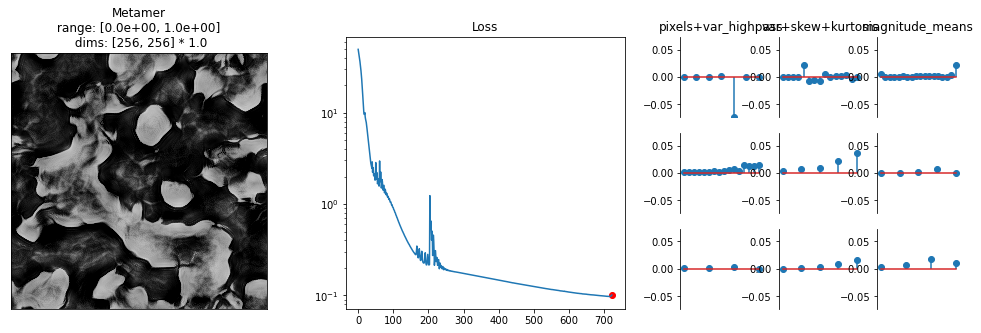

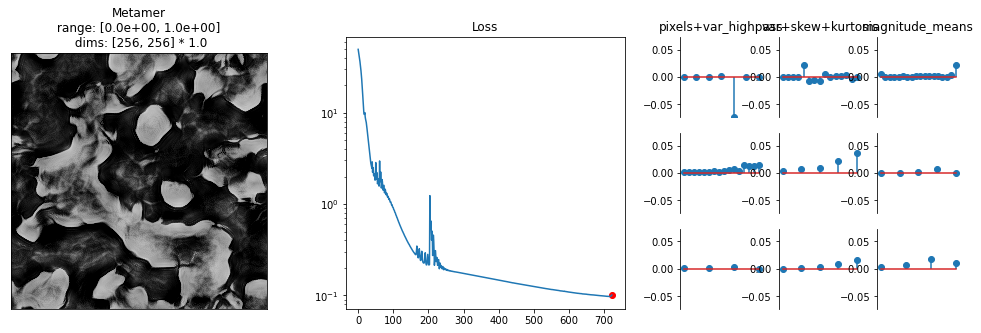

In [35]:
# model.plot_representation(data=met.representation_error());
# met.plot_representation_error();
met.plot_synthesis_status()


In [ ]:
# COMPARISON between models

# function to to load files
def load_images(files,n):
    ims = torch.zeros(len(files),1,n,n)
    
    for ii,f in enumerate(files):
        im = po.load_images(f)
        ims[ii,0,:,:] = im[0,0,:n,:n]
    return ims

def run_portilla_simoncelli(ims):
    n = ims.shape[3]
    y_python = torch.zeros(ims.shape[0],1,2461)
    model_python = po.simul.Portilla_Simoncelli([n,n],n_scales=4, n_orientations=4, spatial_corr_width=9,use_true_correlations=True)
    
    y_matlab = torch.zeros(ims.shape[0],1,2456)
    model_matlab = po.simul.Portilla_Simoncelli([n,n],n_scales=4, n_orientations=4, spatial_corr_width=9,use_true_correlations=False)

    for ii in tqdm(range(0,ims.shape[0])):
        y_python[ii,0,:] = model_python(ims[ii,0,:,:])
        y_matlab[ii,0,:] = model_matlab(ims[ii,0,:,:])
    
    return y_python, y_matlab

def compute_loss(y1,y2):
    
    return torch.norm(y1.squeeze()-y2.squeeze(),p=2,dim=1)/torch.norm(y2.squeeze(),p=2,dim=1)


In [ ]:
n = 256;
# # Load original images
# files = ls(directory)
# originals = load_images(files,n)

# # Load MATLAB images
# matlab_dir = '/Users/kathrynbonnen/Documents/ps-samples-256/matlab/'
# matlab_files = [glob.glob(matlab_dir + ff.split('/')[-1].split('.')[0] + '*')[0] for ff in files]
# matlab = load_images(matlab_files,n)

# # Load python images
# python_dir = '/Users/kathrynbonnen/Documents/ps-samples-256/python/'
# python_files = [glob.glob(python_dir + 'full_range' + ff.split('/')[-1].split('.')[0] + '*')[0] for ff in files]
# python = load_images(python_files,n)

# Load python low noise images
python_dir = '/Users/kathrynbonnen/Documents/ps-samples-256/python/'
python_files = [glob.glob(python_dir + 'low_noise_' + ff.split('/')[-1].split('.')[0] + '*')[0] for ff in files]
python_low = load_images(python_files,n)


In [ ]:
# y_orig_python, y_orig_matlab = run_portilla_simoncelli(originals)
# y_mat_python, y_mat_matlab = run_portilla_simoncelli(matlab)
# y_py_python, y_py_matlab = run_portilla_simoncelli(python)
y_pyl_python, y_pyl_matlab = run_portilla_simoncelli(python_low)


In [ ]:
mat_loss_python = compute_loss(y_mat_python,y_orig_python).detach()
mat_loss_matlab = compute_loss(y_mat_matlab,y_orig_matlab).detach()

py_loss_python = compute_loss(y_py_python,y_orig_python).detach()
py_loss_matlab = compute_loss(y_py_matlab,y_orig_matlab).detach()

pyl_loss_python = compute_loss(y_pyl_python,y_orig_python).detach()
pyl_loss_matlab = compute_loss(y_pyl_matlab,y_orig_matlab).detach()

In [ ]:
fig, ax = plt.subplots(2,2)
ref = [.001,1]
ax[0,0].plot(mat_loss_python,py_loss_python,'.')
ax[0,0].plot(ref,ref)
ax[0,0].set(yscale='log', xscale='log',ylabel='python optimization loss',
         title='normalized/full-range')

# ax[0,1].plot(mat_loss_matlab,py_loss_matlab,'.')
# ax[0,1].plot([10,10**4],[10,10**4])
# ax[0,1].set(yscale='log', xscale='log', title='un-normalized/full-range')

ax[1,0].plot(mat_loss_python,pyl_loss_python,'.')
ax[1,0].plot(ref,ref)
ax[1,0].set(yscale='log', xscale='log', xlabel='matlab optimization loss',
            ylabel='python optimization loss',title='normalized/low-noise')

# ax[1,1].plot(mat_loss_matlab,pyl_loss_matlab,'.')
# ax[1,1].plot([10,10**4],[10,10**4])
# ax[1,1].set(yscale='log', xscale='log', xlabel='matlab optimization loss',title='un-normalized/low-noise')
fig.tight_layout()
plt.show()

In [ ]:
print((mat_loss_python>py_loss_python).sum()/787,
(mat_loss_python>pyl_loss_python).sum()/787)